In [ ]:
# Tesseract OCR motorunu ve Türkçe dil paketini kuralım
print("Tesseract OCR kuruluyor...")
!apt-get update > /dev/null
!apt-get install -y tesseract-ocr tesseract-ocr-tur > /dev/null
print("Tesseract kurulumu tamamlandı.")

# Gerekli Python kütüphanelerini kuralım (doctr, PyTorch backend ile birlikte)
print("Python kütüphaneleri kuruluyor...")
!pip install "python-doctr[torch]" pytesseract tqdm -q
print("Kütüphane kurulumları tamamlandı.")

# Install other required dependencies for OpenCV and Tesseract
!pip install opencv-python-headless pytesseract numpy matplotlib

In [22]:
import os
import pytesseract
import numpy as np
import pandas as pd
import json
import glob
import torch
import re
from sentence_transformers import SentenceTransformer, util
from typing import List, Dict
from pytesseract import image_to_data, Output
from tqdm.notebook import tqdm
from skimage.filters import threshold_sauvola
from scipy.ndimage import rotate
from difflib import get_close_matches
import matplotlib.pyplot as plt
from google.colab import files, drive  # For file uploads and Google Drive mounting
from google.colab.patches import cv2_imshow  # For displaying images in Colab
import cv2
# from skimage.filters import threshold_sauvola
from PIL import Image
# Import doctr for OCR
from doctr.io import DocumentFile
from doctr.models import ocr_predictor, db_resnet50, detection_predictor
import tempfile
import unicodedata
from collections import Counter
from sklearn.cluster import DBSCAN
print("Installed dependencies.")


Installed dependencies.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
def load_doctr_model():
    """
    Load the Doctr OCR model.

    Returns:
        model (doctr.models.ocr_predictor): The loaded OCR predictor model in evaluation mode.
                                             Returns None if loading fails.
    """
    try:
        _device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = ocr_predictor(
            pretrained=True,
            det_arch='db_resnet50',
            reco_arch='crnn_vgg16_bn'
        ).to(_device)
        model.eval()  # Set model to evaluation mode
        print(f"Doctr OCR model loaded on {_device}.")
        return model
    except Exception as e:
        print(f"ERROR: Doctr model could not be loaded: {e}. OCR functionality will be limited.")
        return None

In [27]:
doctr_model = load_doctr_model()

  0%|          | 0/102021912 [00:00<?, ?it/s]

  0%|          | 0/63303144 [00:00<?, ?it/s]

Doctr OCR model loaded on cpu.


In [54]:
keywords_for_detection = [
    'TOPLAM', 'TUTAR', 'KDV', 'TL', 'FATURA', 'TARİH', 'SAAT', 'İŞLEM', 'MÜŞTERİ', 'BAŞARILI',
    'SATIŞ', 'TUTARI', 'YERMİNAL', 'GARANTİ', 'ONAY', 'MERSIS', 'KART', 'BANKA', 'NO', 'ADET',
    'ISLEM', 'PARAMETRE', 'YUKLEME', 'TERMİNAL', 'ISYERİ', 'TERMINAL', 'BATCH', 'GARANTI BBVA',
    'DENIZBANK', 'TOPKDV', '1,00 TL', 'SATIŞ TUTARI', 'İŞLEM TUTARI','IPTAL','İPTAL','ISYERI'
]

# Function Explanations

- **rotate_image_precise**  
  Rotates an image without cropping, ensuring no text is lost.
- **estimate_skew_hough**  
  Detects and returns the small angle of a document's tilt.
- **projection_variance_score**  
  A quick way to score how straight text lines are; higher is better.
- **compute_avg_conf**  
  Calculates the average OCR confidence to compare different rotations.
- **count_keywords**  
  Counts specific keywords to help find the correct document orientation.
- **find_best_orientation**  
  Determines the best coarse rotation (0°, 90°, etc.) for the image.
- **correct_orientation_with_skew**  
  The main function that runs the entire pipeline to straighten the image.

In [64]:
def rotate_image_precise(image, angle, background_color=(255, 255, 255)):
    """
    Why used:
      - Apply arbitrary-angle rotation WITHOUT cropping, so no text is lost.
      - Used for both coarse (0/90/180/270) and fine skew corrections before OCR.
    """
    if angle == 0: return image
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos, sin = np.abs(M[0, 0]), np.abs(M[0, 1])
    nW, nH = int((h * sin) + (w * cos)), int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]
    return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=background_color)

def estimate_skew_hough(image):
    """
    Why used:
      - After coarse rotation, receipts may still be slightly tilted.
      - Detects small skew via Hough lines and returns a robust median angle.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inverted = cv2.bitwise_not(gray)
    thresh = cv2.adaptiveThreshold(inverted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    dilated = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=1)
    edges = cv2.Canny(dilated, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 150,
                            minLineLength=100, maxLineGap=20)
    angles = []
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            if x2 == x1: continue
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if -45 < angle < 45:
                angles.append(angle)
    return np.median(angles) if angles else 0

def projection_variance_score(img):
    """
    Why used:
      - Cheap numeric proxy for “how straight” text lines are.
      - Enables micro-refinement by comparing nearby angles (higher = better).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)
    proj = np.sum(inverted, axis=1)
    return np.var(proj)

def compute_avg_conf(data):
    """
    Why used:
      - Orientation selection needs an OCR quality signal.
      - Average token confidence is a stable metric to compare rotations.
    """
    confs = []
    for txt, conf in zip(data['text'], data['conf']):
        try:
            val = float(conf)
            if txt.strip() and 0 < val < 100:
                confs.append(val)
        except:
            continue
    return np.mean(confs) if confs else 0

def count_keywords(text, keywords):
    """
    Why used:
      - Receipts contain domain-specific tokens (TOPLAM, ONAY, etc.).
      - Acts as a prior to break ties when OCR confidences are close.
    """
    text = text.upper()
    return sum(text.count(k.upper()) for k in keywords)

def find_best_orientation(image, keywords, lang='tur'):
    """
    Why used:
      - Doctr is rotation-sensitive; choose best of 0/90/180/270 FIRST.
      - Scores each angle by (keyword hits + OCR confidence), with a small angle penalty,
        then returns the top candidate to feed into skew correction.
    """
    best_img = image
    best_angle = 0
    best_score = -1
    best_conf = 0
    best_kw_count = 0

    angle_penalty = {
        0: 1.0,
        90: 0.85,
        180: 0.7,
        270: 0.85
    }

    for angle in [0, 90, 180, 270]:
        rotated = rotate_image_precise(image, angle)
        data = pytesseract.image_to_data(rotated, lang=lang, output_type=Output.DICT)
        conf = compute_avg_conf(data)
        text = " ".join(data['text'])
        kw_count = count_keywords(text, keywords)

        # Apply penalty to prefer natural upright when signals tie
        base_score = kw_count * 1000 + conf
        final_score = base_score * angle_penalty.get(angle, 0.7)

        if final_score > best_score:
            best_score = final_score
            best_img = rotated
            best_angle = angle
            best_conf = conf
            best_kw_count = kw_count

    return best_img, best_angle

def correct_orientation_with_skew(image, keywords=None, lang='tur+eng',
                                  skew_range=5, step=1.0, top_n_angles=3):
    """
    Why used:
      - Single entry point to produce a Doctr-ready image.
      - Pipeline: coarse rotation → small skew estimation → optional micro-refine.
      - Returns final image + total angle for audit/reproducibility.
    """
    # Step 1: Try 0°, 90°, 180°, 270°
    upright_img, base_angle = find_best_orientation(image, keywords, lang=lang)

    # Step 2: Estimate fine skew angle
    skew_angle = estimate_skew_hough(upright_img)
    corrected_img = rotate_image_precise(upright_img, skew_angle)

    # Step 3: Optionally refine skew using projection variance
    # print("Refining skew...")
    angles = np.arange(skew_angle - skew_range, skew_angle + skew_range + step, step)
    scored_angles = []
    for a in angles:
        r = rotate_image_precise(upright_img, a)
        score = projection_variance_score(r)
        scored_angles.append((a, score))

    top_angles = sorted(scored_angles, key=lambda x: -x[1])[:top_n_angles]
    best_conf = compute_avg_conf(pytesseract.image_to_data(corrected_img, lang=lang, output_type=Output.DICT))
    best_img = corrected_img
    best_angle = base_angle + skew_angle

    for a, _ in top_angles:
        rotated = rotate_image_precise(upright_img, a)
        data = pytesseract.image_to_data(rotated, lang=lang, output_type=Output.DICT)
        conf = compute_avg_conf(data)
        if conf > best_conf:
            best_conf = conf
            best_img = rotated
            best_angle = base_angle + a

    return best_img, best_angle

In [65]:
image_path = "/content/drive/MyDrive/deneme/Copy of 490837856-1-ÖKC Dokumani - IMG_20250527_094719.jpg"

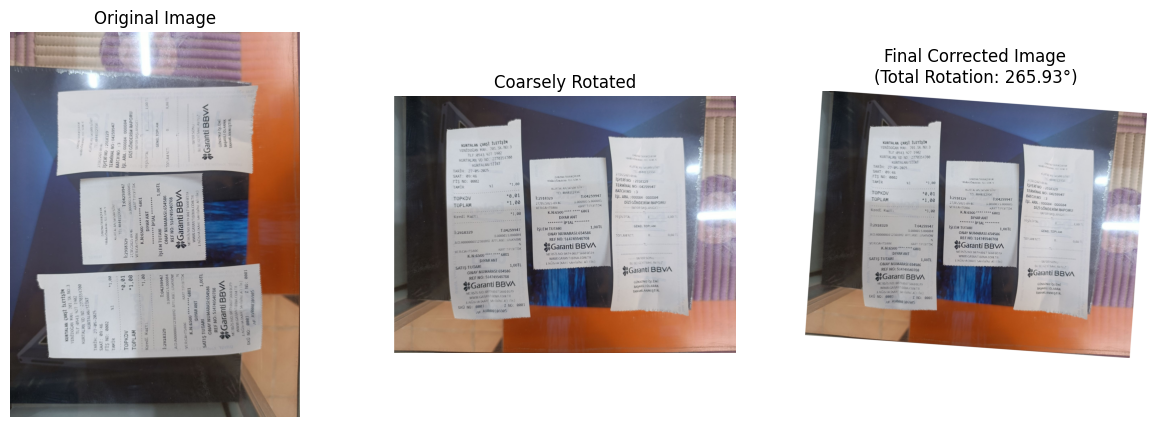

In [66]:
# --- Main Script to use the functions ---
try:
    # Open and load the image using OpenCV
    img_cv2 = cv2.imread(image_path)
    if img_cv2 is None:
        print(f"Error: The file at '{image_path}' was not found or could not be loaded. Please double-check the path.")
    else:
        # Get the original image dimensions for the plot
        (height, width) = img_cv2.shape[:2]

        # Correct the orientation and skew using the new pipeline
        corrected_img, total_angle = correct_orientation_with_skew(img_cv2, keywords=keywords_for_detection)

        # Display the images
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        # OpenCV loads images as BGR, so we convert to RGB for correct display with matplotlib
        plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # Coarsely Rotated Image (by `base_angle` from `find_best_orientation`)
        # This gives an intermediate look at the result of the first step.
        upright_img, _ = find_best_orientation(img_cv2, keywords=keywords_for_detection)
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(upright_img, cv2.COLOR_BGR2RGB))
        plt.title('Coarsely Rotated')
        plt.axis('off')

        # Final Corrected Image
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Final Corrected Image\n(Total Rotation: {total_angle:.2f}°)')
        plt.axis('off')

        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [15]:
def preprocess_for_classification(image, use_clahe=True, sharpen=True, visualize=True):
    """
    Apply CLAHE (on L channel in LAB) and optional sharpening.
    Keeps 3 channels and returns RGB (Doctr-ready).
    """
    import cv2, numpy as np
    import matplotlib.pyplot as plt

    if image is None:
        raise ValueError("Input image is None")

    # Ensure 3-channel BGR
    if image.ndim == 2:
        bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:
        bgr = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    else:
        bgr = image

    # CLAHE
    if use_clahe:
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        L = clahe.apply(L)
        lab = cv2.merge((L, A, B))
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        if visualize:
            plt.figure(); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
            plt.title('CLAHE'); plt.axis('off'); plt.show()

    # Sharpen
    if sharpen:
        kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32)
        bgr = cv2.filter2D(bgr, -1, kernel)
        if visualize:
            plt.figure(); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
            plt.title('Sharpened'); plt.axis('off'); plt.show()

    # Return RGB for Doctr
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


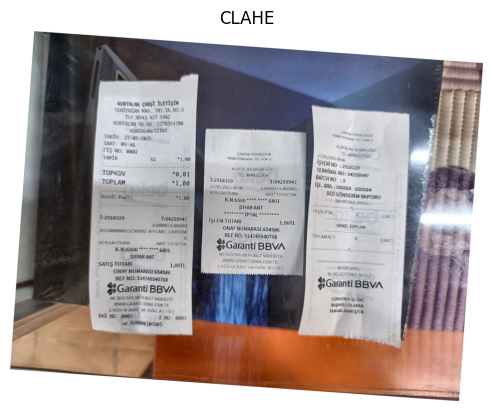

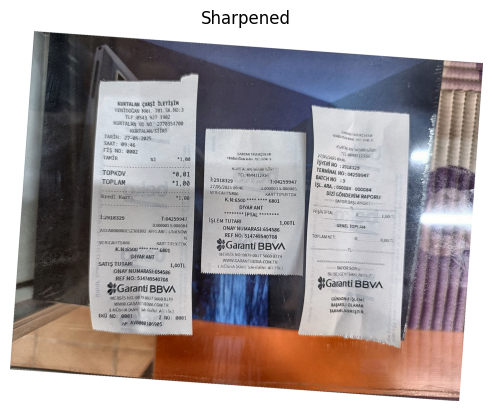

In [16]:
x_cls = preprocess_for_classification(corrected_img, use_clahe=True, sharpen=True, visualize=True)

In [23]:
def normalize_ocr_text(text: str) -> str:
    # 1) Uppercase
    text = text.upper()
    # 2) Remove accents (İ -> I, Ş -> S, etc.)
    text = unicodedata.normalize("NFKD", text)
    text = "".join([c for c in text if not unicodedata.combining(c)])
    # 3) Replace multiple spaces with single
    text = re.sub(r"\s+", " ", text)
    # 4) Strip edges
    return text.strip()

In [24]:
def ocr_with_doctr(bgr, doctr_model):
    H, W = bgr.shape[:2]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    with torch.no_grad():
        res = doctr_model([rgb])
    page = res.pages[0]

    words = []
    for block in page.blocks:
        for line in block.lines:
            for w in line.words:
                txt = (w.value or "").strip()
                if not txt:
                    continue
                (x1n,y1n),(x2n,y2n) = w.geometry
                x1,y1 = int(x1n*W), int(y1n*H)
                x2,y2 = int(x2n*W), int(y2n*H)
                words.append({
                    "text": txt,
                    "normalized_text": normalize_ocr_text(txt),
                    "box": [x1,y1,x2,y2],
                    "center": [(x1+x2)//2, (y1+y2)//2],
                    "confidence": float(getattr(w, "confidence", 1.0)),
                })
    return words, (H, W), page

In [41]:
def analyze_receipt_words(rotated_image, words, image_shape, return_vis=True):
    """
    Clusters words and visualizes the result.
    Expects cluster_receipts_by_centroids(...) to return lists of word INDICES.
    """
    import matplotlib.pyplot as plt
    H, W = image_shape

    clusters = cluster_receipts_by_centroids(words, (H, W))
    vis = rotated_image.copy() if return_vis else None
    if vis is None or not clusters:
        return vis

    # Robust colormap getter across Matplotlib versions
    N = max(len(clusters), 1)
    cmap = None
    try:
        # Newer Matplotlib (>=3.7)
        cmap = plt.colormaps.get_cmap('hsv', N)
    except Exception:
        try:
            # Older signature still supporting N
            cmap = plt.get_cmap('hsv', N)
        except Exception:
            # Oldest fallback: no N support
            cmap = plt.get_cmap('hsv')

    for i, idx_list in enumerate(clusters):
        if not idx_list:
            continue

        xs1 = [words[idx]["box"][0] for idx in idx_list]
        ys1 = [words[idx]["box"][1] for idx in idx_list]
        xs2 = [words[idx]["box"][2] for idx in idx_list]
        ys2 = [words[idx]["box"][3] for idx in idx_list]
        x1, y1, x2, y2 = min(xs1), min(ys1), max(xs2), max(ys2)

        # Pick a stable color per cluster
        rgba = cmap(i / N) if hasattr(cmap, "__call__") else cmap(i % N)
        r, g, b = int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255)
        color = (r, g, b)

        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)
        cv2.putText(vis, f'Cluster {i}', (x1, max(0, y1-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return vis


# Word Clustering and Merging Explained

This module groups OCR-detected words into logical text blocks (e.g., separate receipts) using **DBSCAN** and merges overlapping clusters.

## Why DBSCAN?
- **No need to predefine clusters** – Automatically finds the number of text groups (receipts) without manual input.
- **Handles irregular shapes** – Works even if receipts are skewed or curved in OCR coordinates.
- **Noise filtering** – Isolated OCR errors are marked as noise instead of forming false clusters.
- **Adaptive to scale** – Parameters (`eps`, `min_samples`) can be tuned automatically for varying receipt sizes and layouts.

## Clustering
- **adaptive_dbscan_params** - Auto-calculates DBSCAN `eps` and `min_samples` based on word spacing for robust clustering.  
- **cluster_receipts_by_centroids** - Runs DBSCAN on word center coordinates, assigning each to a cluster or marking as noise.
## Main Pipeline
- **cluster_receipts** – Orchestrates:  
  1. (Optional) Auto-parameter tuning.  
  2. Initial DBSCAN clustering.  
  3. Remove tiny/noisy clusters.  
  4. Create bounding boxes.  
  5. Merge overlapping clusters.  
  6. Return cluster word indices + final box.


In [49]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# ---------- adaptive params ----------
def adaptive_dbscan_params(words, H, W):
    diag = float(np.hypot(H, W))
    if not words:
        return 0.08, 5
    centers = np.array([w["center"] for w in words], dtype=float)
    if len(centers) > 1:
        d, _ = NearestNeighbors(n_neighbors=2).fit(centers).kneighbors(centers)
        avg = float(np.mean(d[:, 1]))
    else:
        avg = 0.05 * diag
    eps_frac = min(0.15, max(0.05, (avg / diag) * 1.5))
    n = len(words)
    min_samples = 3 if n < 30 else (5 if n < 80 else 8)
    return eps_frac, min_samples

# ---------- core clustering ----------
def cluster_receipts_by_centroids(words, image_shape, eps_frac=0.08, min_samples=5):
    if not words:
        return []
    H, W = image_shape
    X = np.array([w["center"] for w in words], dtype=float)
    eps = float(np.hypot(W, H) * eps_frac)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)

    clusters = []
    for lab in sorted(set(labels)):
        if lab < 0:
            continue  # noise
        idx = np.where(labels == lab)[0].tolist()
        clusters.append(idx)
    return clusters  # list[list[int]] of word indices

# ---------- utilities ----------
def _bbox_of_indices(words, idxs, H, W, pad_frac=0.03):
    xs1 = [words[i]["box"][0] for i in idxs]
    ys1 = [words[i]["box"][1] for i in idxs]
    xs2 = [words[i]["box"][2] for i in idxs]
    ys2 = [words[i]["box"][3] for i in idxs]
    x1, y1, x2, y2 = min(xs1), min(ys1), max(xs2), max(ys2)
    px, py = int(pad_frac * (x2 - x1)), int(pad_frac * (y2 - y1))
    x1, y1 = max(0, x1 - px), max(0, y1 - py)
    x2, y2 = min(W, x2 + px), min(H, y2 + py)
    return (x1, y1, x2, y2)

def _iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1, inter_y1 = max(ax1, bx1), max(ay1, by1)
    inter_x2, inter_y2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, inter_x2 - inter_x1), max(0, inter_y2 - inter_y1)
    inter = iw * ih
    if inter == 0: return 0.0
    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    return inter / float(area_a + area_b - inter + 1e-6)

def _merge_overlapping(bboxes, clusters, iou_thresh=0.25):
    """Greedy merge by IoU threshold."""
    order = list(range(len(bboxes)))
    used = [False] * len(bboxes)
    merged_boxes, merged_clusters = [], []

    for i in order:
        if used[i]: continue
        cur_box = bboxes[i]
        cur_idxs = set(clusters[i])
        used[i] = True
        changed = True
        while changed:
            changed = False
            for j in order:
                if used[j]: continue
                if _iou(cur_box, bboxes[j]) >= iou_thresh:
                    # merge
                    bx = bboxes[j]
                    cur_box = (min(cur_box[0], bx[0]), min(cur_box[1], bx[1]),
                               max(cur_box[2], bx[2]), max(cur_box[3], bx[3]))
                    cur_idxs.update(clusters[j])
                    used[j] = True
                    changed = True
        merged_boxes.append(cur_box)
        merged_clusters.append(sorted(list(cur_idxs)))
    return merged_boxes, merged_clusters


def cluster_receipts(words, image_shape,
                     use_adaptive=True,
                     eps_frac=0.08, min_samples=5,
                     min_words=10, pad_frac=0.03,
                     merge_iou=0.25):
    """
    Returns: list of dicts:
      { "word_indices": [...], "bbox": (x1,y1,x2,y2) }
    """
    H, W = image_shape

    # choose params
    if use_adaptive:
        eps_frac, min_samples = adaptive_dbscan_params(words, H, W)

    # cluster
    raw_clusters = cluster_receipts_by_centroids(words, (H, W), eps_frac=eps_frac, min_samples=min_samples)

    # filter tiny clusters
    raw_clusters = [idxs for idxs in raw_clusters if len(idxs) >= min_words]
    if not raw_clusters:
        return []

    # bboxes
    bboxes = [_bbox_of_indices(words, idxs, H, W, pad_frac=pad_frac) for idxs in raw_clusters]

    # optional merge
    if merge_iou and len(raw_clusters) > 1:
        bboxes, merged_clusters = _merge_overlapping(bboxes, raw_clusters, iou_thresh=merge_iou)
    else:
        merged_clusters = raw_clusters

    # build outputs
    out = []
    for idxs, box in zip(merged_clusters, bboxes):
        out.append({"word_indices": idxs, "bbox": box})
    return out


In [44]:
image_path = "/content/drive/MyDrive/deneme/Copy of 490832738-3-ÖKC Dokumani - 20250527_115247.jpg"

In [56]:
import cv2
import numpy as np
from typing import List, Dict, Tuple, Union

def draw_word_bboxes(
    bgr: np.ndarray,
    words: List[Dict],
    color: Tuple[int,int,int]=(0, 255, 255),
    thickness: int = 1,
    show_index: bool = False,
) -> np.ndarray:
    """
    Draws every word bounding box returned by Doctr.
    words: list of dicts with keys: 'box' -> [x1,y1,x2,y2], 'text' (optional)
    """
    vis = bgr.copy()
    for i, w in enumerate(words):
        x1, y1, x2, y2 = map(int, w["box"])
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, thickness)
        if show_index:
            cv2.putText(vis, str(i), (x1, max(0, y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    return vis


def draw_cluster_bboxes(
    bgr: np.ndarray,
    clusters: List[Union[List[int], List[Dict]]],
    words: List[Dict],
    pad_frac: float = 0.03,
    palette: str = "hsv"
) -> np.ndarray:
    """
    Draws one bounding box per cluster.
    clusters: list of clusters, where each cluster is either:
              - list of word indices (ints) into `words`, or
              - list of word dicts (same shape as items in `words`)
    words: full word list (used when clusters are indices)
    pad_frac: fractional padding added to each cluster bbox
    """
    H, W = bgr.shape[:2]
    vis = bgr.copy()

    # pick colors
    n = max(1, len(clusters))
    cmap = getattr(cv2, "applyColorMap", None)
    # simple deterministic colors from HSV wheel
    def idx_color(i):
        hue = int(180 * (i / max(1, n)))
        col = cv2.cvtColor(np.uint8([[[hue, 200, 255]]]), cv2.COLOR_HSV2BGR)[0,0]
        return int(col[0]), int(col[1]), int(col[2])

    for i, cl in enumerate(clusters):
        # unify to list of word dicts
        if len(cl) == 0:
            continue
        if isinstance(cl[0], int):
            cluster_words = [words[idx] for idx in cl]
        else:
            cluster_words = cl  # already dicts

        xs1 = [w["box"][0] for w in cluster_words]
        ys1 = [w["box"][1] for w in cluster_words]
        xs2 = [w["box"][2] for w in cluster_words]
        ys2 = [w["box"][3] for w in cluster_words]
        if not xs1:
            continue

        x1, y1, x2, y2 = min(xs1), min(ys1), max(xs2), max(ys2)

        # padding
        px = int(pad_frac * (x2 - x1))
        py = int(pad_frac * (y2 - y1))
        x1 = max(0, x1 - px); y1 = max(0, y1 - py)
        x2 = min(W, x2 + px); y2 = min(H, y2 + py)

        col = idx_color(i)
        cv2.rectangle(vis, (x1, y1), (x2, y2), col, 2)
        cv2.putText(vis, f"Cluster {i}", (x1, max(0, y1 - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2, cv2.LINE_AA)

    return vis

In [58]:
def group_boxes_into_lines(boxes, y_threshold=20):
    """Groups word-boxes into lines by vertical proximity."""
    if not boxes:
        return []
    sorted_boxes = sorted(boxes, key=lambda b: b["center"][1])
    lines, current = [], [sorted_boxes[0]]
    for b in sorted_boxes[1:]:
        if abs(b["center"][1] - current[-1]["center"][1]) <= y_threshold:
            current.append(b)
        else:
            lines.append(current)
            current = [b]
    lines.append(current)
    return lines

Starting orientation correction...


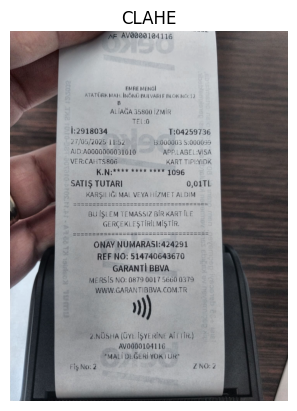

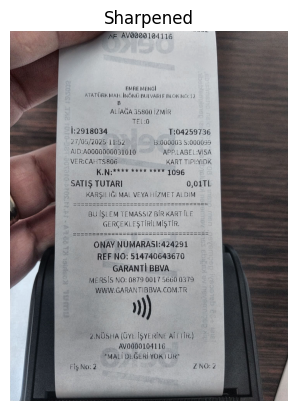

Final total rotation angle applied: -2.00 degrees.
Performing OCR on corrected image with Doctr model...


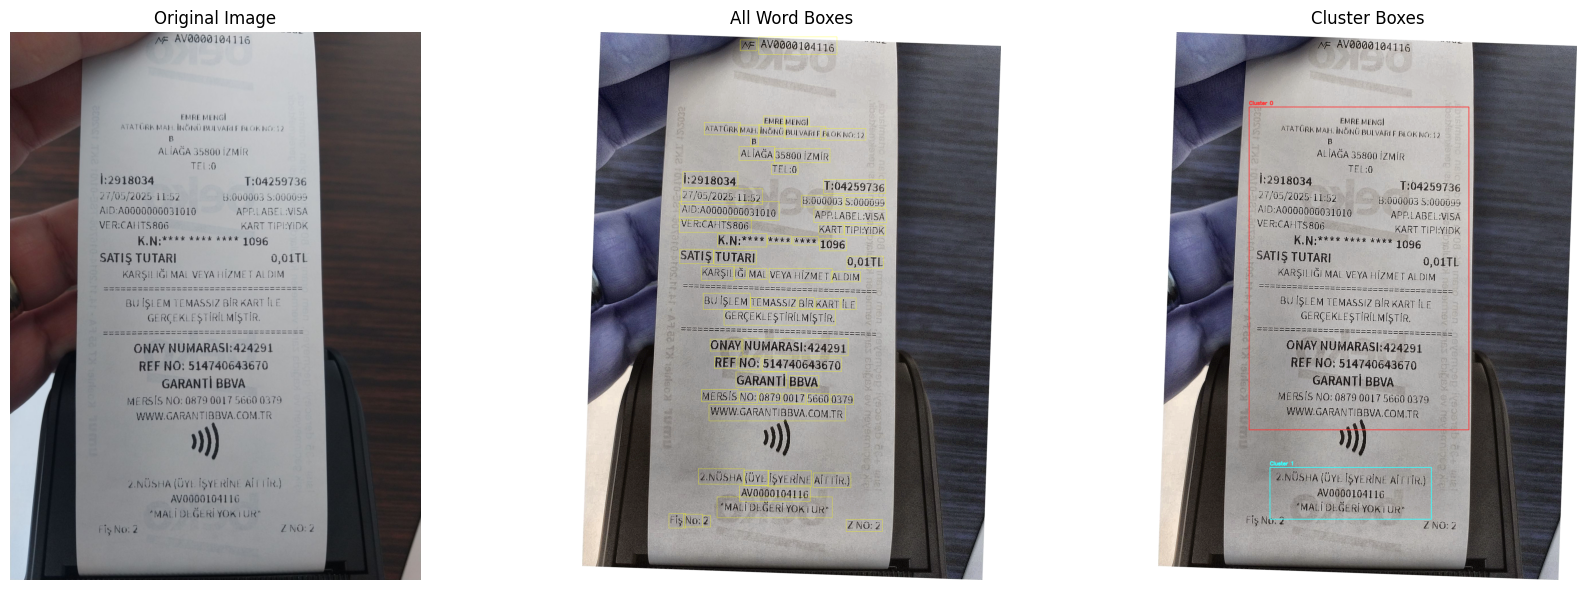

In [60]:
# --- Main Execution Block ---
def main(image_path=None):
    try:
        # Load image
        if image_path:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not load image from path: {image_path}. Attempting to download sample image instead.")

        else:
            print("No image path provided. Downloading sample image...")


        if img is None:
            print("Error: Could not load or download sample image.")
            return


        # Step 1: Preprocess & orientation correction
        print("Starting orientation correction...")
        preprocessed_img = preprocess_for_classification(img)
        corrected_img, total_angle = correct_orientation_with_skew(preprocessed_img, keywords=keywords_for_detection)
        print(f"Final total rotation angle applied: {total_angle:.2f} degrees.")

        # Step 2: Doctr OCR
        print("Performing OCR on corrected image with Doctr model...")
        words, image_shape, _ = ocr_with_doctr(corrected_img, doctr_model)
        if not words:
            print("No words detected.")
            return

        # Step 3: Draw all word boxes
        vis_words = draw_word_bboxes(corrected_img, words, color=(0,255,255), thickness=1, show_index=False)

        # Step 4: Cluster & draw cluster boxes
        clusters = cluster_receipts_by_centroids(words, image_shape)
        vis_clusters = draw_cluster_bboxes(corrected_img, clusters, words)

        # Step 5: Show images
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(vis_words, cv2.COLOR_BGR2RGB))
        plt.title("All Word Boxes")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(vis_clusters, cv2.COLOR_BGR2RGB))
        plt.title("Cluster Boxes")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


main(image_path="/content/drive/MyDrive/deneme/Copy of 490832738-3-ÖKC Dokumani - 20250527_115247.jpg")


In [50]:
def compute_receipt_score(
    line_texts,
    keywords_for_detection,
    kw_weight=0.4,
    amt_weight=0.6,
    date_weight=0.5,
    time_weight=0.4,
    threshold=1.8,
    return_debug=False,
    print_debug=False,
):
    """
    Evaluates OCR-extracted text to decide whether it likely represents a receipt, using a weighted scoring system based
    on keyword presence and regex-detected patterns (amount, date, time).

    line_texts: list[str]  -> e.g. ["ISYERI NO 12345 TUTAR 12,34 TL", ...]
    keywords_for_detection: list[str] of domain tokens (TOPLAM, TUTAR, ...)
    Returns a dict with score components and a boolean is_receipt.
    """
    import re

    # 1) Flatten + normalize once
    full = " ".join(line_texts or [])
    full_norm = normalize_ocr_text(full)  # your helper (upper + strip accents + collapse spaces)

    # 2) Keyword hits (dedup list of kws to avoid double work)
    norm_kws = []
    seen = set()
    for k in (keywords_for_detection or []):
        nk = normalize_ocr_text(k)
        if nk and nk not in seen:
            seen.add(nk)
            norm_kws.append(nk)

    matched_kws = [k for k in norm_kws if k in full_norm]
    # count occurrences (so repeated appearances increase score slightly)
    kw_hits = sum(full_norm.count(k) for k in matched_kws)

    # 3) Regex signals (+ capture examples for debug)
    amount_re = re.compile(r'\b\d{1,4}[.,]\d{2}\s*(?:TL|TRY)?\b')   # 12,34 TL / 12.34 TL / 12,34
    date_re   = re.compile(r'\b\d{2}[./-]\d{2}[./-]\d{2,4}\b')      # 27/05/2025, 27.05.25, etc.
    time_re   = re.compile(r'\b\d{2}[:.]\d{2}(?::\d{2})?\b')        # 11:52 or 11:52:47

    amount_matches = amount_re.findall(full_norm)
    date_matches   = date_re.findall(full_norm)
    time_matches   = time_re.findall(full_norm)

    has_amount = bool(amount_matches)
    has_date   = bool(date_matches)
    has_time   = bool(time_matches)

    # 4) Score (linear combo of signals)
    kw_contrib   = kw_weight  * kw_hits
    amt_contrib  = amt_weight * int(has_amount)
    date_contrib = date_weight* int(has_date)
    time_contrib = time_weight* int(has_time)

    score = kw_contrib + amt_contrib + date_contrib + time_contrib
    is_receipt = score >= threshold

    result = {
        "score": round(score, 3),
        "kw_hits": int(kw_hits),
        "has_amount": has_amount,
        "has_date": has_date,
        "has_time": has_time,
        "is_receipt": is_receipt,
    }

    if return_debug:
        result["debug"] = {
            "text_preview": full_norm[:300],
            "matched_keywords": matched_kws,         # normalized forms
            "amount_matches": amount_matches[:10],
            "date_matches": date_matches[:10],
            "time_matches": time_matches[:10],
            "weights": {
                "kw_weight": kw_weight,
                "amt_weight": amt_weight,
                "date_weight": date_weight,
                "time_weight": time_weight,
                "threshold": threshold,
            },
            "components": {
                "kw_contrib": round(kw_contrib, 3),
                "amt_contrib": round(amt_contrib, 3),
                "date_contrib": round(date_contrib, 3),
                "time_contrib": round(time_contrib, 3),
            },
        }

    if print_debug:
        print(
            f"[receipt_score] score={score:.3f} (kw={kw_contrib:.2f}, amt={amt_contrib:.2f}, "
            f"date={date_contrib:.2f}, time={time_contrib:.2f}) | "
            f"kw_hits={kw_hits} | amount={has_amount} date={has_date} time={has_time} | "
            f"thr={threshold} => is_receipt={is_receipt}"
        )
        if matched_kws:
            print("  matched_keywords:", matched_kws)
        if amount_matches or date_matches or time_matches:
            print("  samples:", {
                "amount": amount_matches[:3],
                "date":   date_matches[:3],
                "time":   time_matches[:3],
            })

    return result

In [51]:
# orchestrator
def image_has_receipt(
    bgr,
    doctr_model,
    keywords_for_detection,
    use_adaptive=True,
    eps_frac=0.08,
    min_samples=5,
    min_words_per_cluster=8,
    score_threshold=1.8,
    return_vis=False,
):
    """
    Returns:
      {
        'is_receipt': bool,
        'best_score': float,
        'best_cluster_idx': int or None,
        'clusters': [
           { 'idxs': [...], 'bbox': (x1,y1,x2,y2), 'score_info': {...}, 'lines': [...]} , ...
        ],
        'vis': (optional annotated image)
      }
    """
    H, W = bgr.shape[:2]

    # 1) OCR
    words, (HH, WW), _ = ocr_with_doctr(bgr, doctr_model)
    if not words:
        return {'is_receipt': False, 'best_score': 0.0, 'best_cluster_idx': None, 'clusters': [], 'vis': bgr if return_vis else None}

    # 2) Clustering
    if use_adaptive:
        eps_frac, min_samples = adaptive_dbscan_params(words, H, W)
    cluster_idxs = cluster_receipts_by_centroids(words, (H, W), eps_frac=eps_frac, min_samples=min_samples)
    cluster_idxs = [idxs for idxs in cluster_idxs if len(idxs) >= min_words_per_cluster]
    if not cluster_idxs:
        return {'is_receipt': False, 'best_score': 0.0, 'best_cluster_idx': None, 'clusters': [], 'vis': bgr if return_vis else None}

    # 3) Score each cluster
    results = []
    for idxs in cluster_idxs:
        cluster_words = [words[i] for i in idxs]

        # lines & texts
        lines = group_boxes_into_lines(cluster_words)
        line_texts = [" ".join(wd["normalized_text"] for wd in line) for line in lines]

        score_info = compute_receipt_score(
            line_texts,
            keywords_for_detection,
            threshold=score_threshold,
            return_debug=True,
            print_debug=False
        )

        # bbox
        xs1 = [w["box"][0] for w in cluster_words]
        ys1 = [w["box"][1] for w in cluster_words]
        xs2 = [w["box"][2] for w in cluster_words]
        ys2 = [w["box"][3] for w in cluster_words]
        x1, y1, x2, y2 = min(xs1), min(ys1), max(xs2), max(ys2)

        results.append({
            "idxs": idxs,
            "bbox": (x1, y1, x2, y2),
            "score_info": score_info,
            "lines": line_texts,
        })

    # 4) Decide at image level
    best_idx = max(range(len(results)), key=lambda i: results[i]["score_info"]["score"])
    best = results[best_idx]
    is_receipt = any(r["score_info"]["is_receipt"] for r in results)

    # 5) Optional visualization
    vis = None
    if return_vis:
        vis = bgr.copy()
        for r in results:
            x1,y1,x2,y2 = r["bbox"]
            ok = r["score_info"]["is_receipt"]
            color = (0,255,0) if ok else (0,165,255)
            cv2.rectangle(vis, (x1,y1), (x2,y2), color, 2)
            cv2.putText(vis, f'{r["score_info"]["score"]:.2f}', (x1, max(0, y1-8)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return {
        "is_receipt": bool(is_receipt),
        "best_score": float(best["score_info"]["score"]),
        "best_cluster_idx": int(best_idx),
        "clusters": results,
        "vis": vis,
    }

Has receipt? True | best score: 7.0


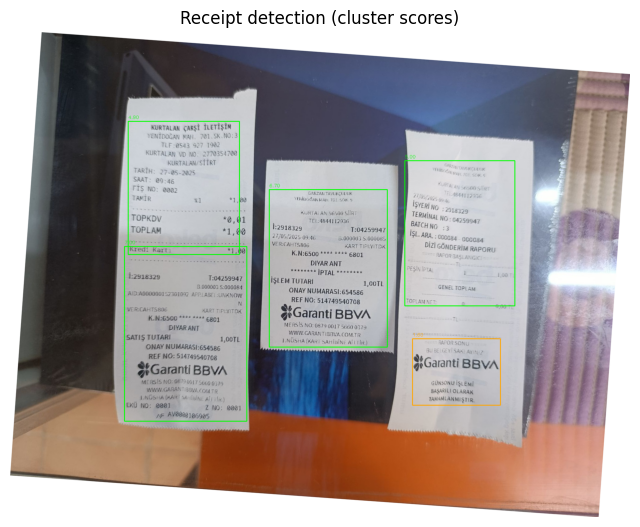

Matched keywords: ['TUTAR', 'TL', 'SATIS', 'TUTARI', 'GARANTI', 'ONAY', 'MERSIS', 'KART', 'NO', 'GARANTI BBVA']
Text preview: *1,00 T:04259947 B.0000035 5:000084 AID:A0000015230102 APPLABEL: :UNKNOW N VER:CAHTS806 KART TIPLYITDK K.N:6500 6801 DIYARANT TUTARI SATIS 1,00TL ONAY NUMARAS:654586 NO: REF 514749540708 * GARANTI BBVA 2 MERSIS NO: 0879001756600379 WWGAGARNTOUA.COM4TR LNOSHA (KART SAHIBINE AINIK) EKU NO: 0001 ZNO: 0


In [59]:
# Assume you already corrected orientation: corrected_img
out = image_has_receipt(
    corrected_img,
    doctr_model,
    keywords_for_detection=keywords_for_detection,
    score_threshold=1.8,
    return_vis=True
)

print("Has receipt?", out["is_receipt"], "| best score:", out["best_score"])
if out["vis"] is not None:
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(out["vis"], cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title("Receipt detection (cluster scores)")
    plt.show()

# Inspect the best cluster’s debug
b = out["clusters"][out["best_cluster_idx"]]
print("Matched keywords:", b["score_info"].get("debug", {}).get("matched_keywords"))
print("Text preview:", b["score_info"].get("debug", {}).get("text_preview"))


# todo
1. deciding on threshold for receipt detection
2. training a small classifier for receipt type classification


### **chatgpt recommendation**:
Right now your receipt detection relies on fixed rule weights and a manual threshold, which can’t adapt well to different banks or layouts. Training a tiny calibrator, like logistic regression, on your existing features (keyword hits, amount/date/time flags, OCR confidence, etc.) would automatically learn the best feature weights and output a calibrated probability. You can generate ~100 quick labels or use high-confidence pseudo-labels from your current rules to train it in minutes.
